In [1]:
# Create a sample log file with the specified data
log_data = """2024-12-18 10:15:32 INFO User logged in
2024-12-18 10:16:02 ERROR Page not found
2024-12-18 10:17:20 INFO Data uploaded successfully"""

# Save the log data to a file
with open('log_file.txt', 'w') as file:
    file.write(log_data)

# Display the log data
print(log_data)


2024-12-18 10:15:32 INFO User logged in
2024-12-18 10:16:02 ERROR Page not found
2024-12-18 10:17:20 INFO Data uploaded successfully


In [2]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName('LogAnalysis').getOrCreate()

# Load the log file into a DataFrame
log_df = spark.read.text('log_file.txt')

# Show the DataFrame
log_df.show(truncate=False)


+---------------------------------------------------+
|value                                              |
+---------------------------------------------------+
|2024-12-18 10:15:32 INFO User logged in            |
|2024-12-18 10:16:02 ERROR Page not found           |
|2024-12-18 10:17:20 INFO Data uploaded successfully|
+---------------------------------------------------+



In [3]:
from pyspark.sql.functions import regexp_extract

# Define regex patterns for timestamp, log level, and message
timestamp_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})'
log_level_pattern = r'(INFO|ERROR|WARN|DEBUG)'
message_pattern = r'(INFO|ERROR|WARN|DEBUG) (.*)'

# Extract columns from the log DataFrame
log_df = log_df.withColumn('Timestamp', regexp_extract('value', timestamp_pattern, 1))
log_df = log_df.withColumn('LogLevel', regexp_extract('value', log_level_pattern, 1))
log_df = log_df.withColumn('Message', regexp_extract('value', message_pattern, 2))

# Drop the original 'value' column
log_df = log_df.drop('value')

# Show the DataFrame with extracted columns
log_df.show(truncate=False)


+-------------------+--------+--------------------------+
|Timestamp          |LogLevel|Message                   |
+-------------------+--------+--------------------------+
|2024-12-18 10:15:32|INFO    |User logged in            |
|2024-12-18 10:16:02|ERROR   |Page not found            |
|2024-12-18 10:17:20|INFO    |Data uploaded successfully|
+-------------------+--------+--------------------------+



In [4]:
from pyspark.sql.functions import count

# Count the occurrences of each log level
log_level_counts = log_df.groupBy('LogLevel').agg(count('*').alias('Count'))

# Show the counts
log_level_counts.show()


+--------+-----+
|LogLevel|Count|
+--------+-----+
|    INFO|    2|
|   ERROR|    1|
+--------+-----+



In [5]:
# Filter and display only the ERROR logs
error_logs = log_df.filter(log_df.LogLevel == 'ERROR')

# Show the ERROR logs
error_logs.show(truncate=False)


+-------------------+--------+--------------+
|Timestamp          |LogLevel|Message       |
+-------------------+--------+--------------+
|2024-12-18 10:16:02|ERROR   |Page not found|
+-------------------+--------+--------------+



In [6]:
from pyspark.sql.functions import hour

# Extract hour from Timestamp
log_df = log_df.withColumn('Hour', hour('Timestamp'))

# Group by hour and count the number of logs in each hour
logs_per_hour = log_df.groupBy('Hour').count().orderBy('Hour')

# Show the number of logs per hour
logs_per_hour.show()


+----+-----+
|Hour|count|
+----+-----+
|  10|    3|
+----+-----+



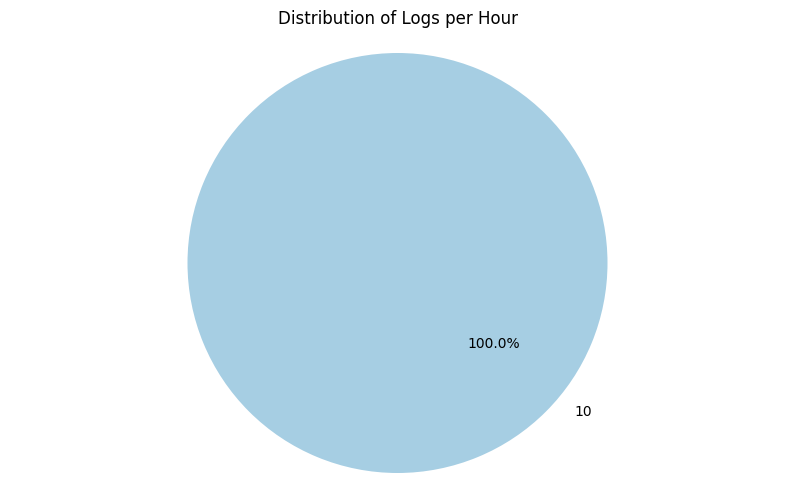

In [9]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
logs_per_hour_pd = logs_per_hour.toPandas()

# Plot the data using a pie chart
plt.figure(figsize=(10, 6))
plt.pie(logs_per_hour_pd['count'], labels=logs_per_hour_pd['Hour'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Logs per Hour')
plt.show()
